In [21]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import matplotlib.pyplot as plt
import numba
from numba import njit
import numpy as np
from pocket_coffea.lib.parton_provenance import reverse_index_array

In [22]:
filename ="/pnfs/psi.ch/cms/trivcat/store/mc/Run3Summer22EENanoAODv12/VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v3/80000/a897cbbf-ea0b-40d5-b850-f9f24a7906a5.root"
# events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100000).events()
print("Events read:", len(events))

Events read: 100000


In [23]:
events.GenPart=ak.with_field(events.GenPart, ak.local_index(events.GenPart, axis=1), "index")
genpart= events.GenPart
single_event=-1
if (single_event!=-1):
    genpart= events.GenPart[single_event]


isQuark = abs(genpart.pdgId) < 7
isHard = genpart.hasFlags(["fromHardProcess"])

quarks = genpart[isQuark & isHard]
quarks = quarks[quarks.genPartIdxMother!=-1]

quarks_mother = genpart[quarks.genPartIdxMother]
quarks_mother_children = quarks_mother.children
quarks_mother_children_isH = ak.sum((quarks_mother_children.pdgId == 25), axis=-1)==2
vbf_quarks = quarks[quarks_mother_children_isH]


print(quarks_mother_children_isH, quarks_mother_children_isH[0])
print(quarks.pdgId, quarks.genPartIdxMother, quarks.index)
print(vbf_quarks.pdgId, vbf_quarks.genPartIdxMother, vbf_quarks.index, genpart[vbf_quarks.genPartIdxMother].pdgId)
print(vbf_quarks.hasFlags(["isFirstCopy"]))


[[True, True, False, False, False, False, ... False, False, False, False, False]] [True, True, False, False, False, False, ... False, False, False, False, False]
[[2, 2, 5, -5, 5, -5, 5, 5, 2, 2, -5, 5, ... [2, 1, 5, -5, 5, -5, 1, 2, 5, -5]] [[0, 0, 10, 10, 11, 11, 12, 14, 5, 4, 15, 17, ... [0, 0, 8, 8, 9, 9, 5, 4, 10, 11]] [[4, 5, 12, 13, 14, 15, 17, 18, 20, 21, ... 4, 5, 10, 11, 12, 13, 14, 16, 19, 21]]
[[2, 2], [2, 1], [4, 1], [4, 1], [1, -1, ... 2, -2], [2, 2], [2, 3], [1, -1], [2, 1]] [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]] [[4, 5], [4, 5], [4, 5], [4, 5], [4, 5], ... [4, 5], [4, 5], [4, 5], [4, 5], [4, 5]] [[2, 2], [1, 1], [2, 2], [2, 2], [-2, -2, ... -1], [2, 2], [1, 1], [-2, -2], [2, 2]]
[[False, False], [False, False], [True, ... True], [True, True], [False, False]]


In [24]:

children_idxG = ak.without_parameters(genpart.childrenIdxG, behavior={})
children_idxG_flat = ak.flatten(children_idxG, axis=1)
genpart_pdgId_flat = ak.flatten(ak.without_parameters(genpart.pdgId, behavior={}), axis=1)
genpart_LastCopy_flat = ak.flatten(ak.without_parameters(genpart.hasFlags(["isLastCopy"]), behavior={}), axis=1)
genpart_pt_flat = ak.flatten(ak.without_parameters(genpart.pt, behavior={}), axis=1)
genparts_flat = ak.flatten(genpart)
genpart_offsets = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genpart, axis=1), allow_missing=True))])
local_index_all = ak.local_index(genpart, axis=1)
local_index_vbf = ak.local_index(vbf_quarks, axis=1)
vbf_quark_idx = ak.to_numpy(vbf_quarks.index+genpart_offsets[:-1], allow_missing=False)
vbf_quarks_pdgId = ak.to_numpy(vbf_quarks.pdgId, allow_missing=False)
nevents=vbf_quark_idx.shape[0]
firstgenpart_idxG = ak.firsts(genpart[:,0].children).genPartIdxMotherG
firstgenpart_idxG_numpy = ak.to_numpy( firstgenpart_idxG, allow_missing=False)


In [25]:
print(genpart_offsets)
print(children_idxG)
print(children_idxG_flat)
print(genpart_pdgId_flat)
print(genpart_LastCopy_flat)
print(genparts_flat.index, ak.num(genparts_flat.index, axis=0))
print(local_index_all, ak.num(local_index_all, axis=1))
print(nevents)
print(vbf_quark_idx)

[      0      53     108 ... 5617077 5617130 5617171]
[[[2, 3, 4, 5], [], [6], [7], [21], ... [], [], [], [5617169], [5617170], [], []]]
[[2, 3, 4, 5], [], [6], [7], [21], ... [], [], [], [5617169], [5617170], [], []]
[2, 2, 25, 25, 2, 2, 25, 25, 25, 25, ... -11, 12, -13, 14, -421, 111, 111, 22, 22]
[False, False, False, False, False, False, ... True, True, True, True, True, True]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40] 5617171
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]] [53, 55, 60, 51, 56, 54, 49, 59, 69, 47, ... 65, 49, 74, 42, 74, 45, 52, 54, 53, 41]
100000
[[      4       5]
 [     57      58]
 [    112     113]
 ...
 [5617027 5617028]
 [5617081 5617082]
 [5617134 5617135]]


In [44]:
@njit
def analyze_parton_from_vbf_quarks(
    vbf_quarks_idx,
    vbf_quarks_pdgId,
    children_idxG_flat,
    genpart_pdgId_flat,
    genpart_offsets,
    genpart_LastCopy_flat,
    genpart_pt_flat,
    nevents,
    firstgenpart_idxG_numpy
):
    prints=False
    # print input array
    if prints:
        print("vbf_quarks_idx", vbf_quarks_idx)
        print("vbf_quarks_pdgId", vbf_quarks_pdgId)
        print("children_idxG_flat", children_idxG_flat)
        print("genpart_pdgId_flat", genpart_pdgId_flat)
        print("genpart_offsets", genpart_offsets)
        print("genpart_LastCopy_flat", genpart_LastCopy_flat)
        print("nevents", nevents)

    # get the children ofthe vbf_quarks which have the same pdgId of the mother iteratively until we reach the last copy

    out = np.zeros(vbf_quarks_idx.shape, dtype="int64")-1

    for iev in range(vbf_quarks_idx.shape[0]):
        if prints: print("Event", iev)
        prints=True if iev==1662 else False
        for ipart in range(vbf_quarks_idx.shape[1]):
            p_id = vbf_quarks_idx[iev][ipart]
            if prints: print("Parton", ipart)
            i=0
            if genpart_LastCopy_flat[p_id]:
                out[iev][ipart] = p_id
                continue
            while not genpart_LastCopy_flat[p_id] and i<5:
                i+=1
                children_idxs = reverse_index_array(children_idxG_flat[p_id],
                                    firstgenpart_idxG_numpy,
                                    genpart_offsets, nevents)
                # children_idxs = children_idxG_flat[p_id]
                if prints: print(children_idxs)

                #get the children with the same pdgId as the mother with highest pt
                max_pt = -1
                max_pt_idx = -1


                # num_pdg_equal=0
                # for child_idx in children_idxs:
                #     if genpart_pdgId_flat[child_idx] == vbf_quarks_pdgId[iev][ipart]:
                #         num_pdg_equal+=1
                # if num_pdg_equal==1:
                #     p_id = children_idxs[0]
                #     break
                # if prints: print("\n\n###################\n\n")


                for child_idx in children_idxs:
                    if prints: print("Child", child_idx)
                    if prints: print(vbf_quarks_pdgId[iev][ipart])
                    if prints: print(genpart_pdgId_flat[child_idx])
                    if genpart_pdgId_flat[child_idx] != vbf_quarks_pdgId[iev][ipart]:
                        continue
                    child_pt = genpart_pt_flat[child_idx]
                    if prints: print(child_pt)
                    if child_pt > max_pt:
                        max_pt_idx = child_idx
                        max_pt = child_pt

                if prints: print("genpart_LastCopy_flat", genpart_LastCopy_flat[max_pt_idx])
                if  genpart_LastCopy_flat[max_pt_idx]:
                    if prints: print("Found child")
                    out[iev][ipart] = max_pt_idx
                if prints: print(p_id, max_pt_idx)
                p_id = max_pt_idx
                if prints: print(p_id, max_pt_idx)
                # break
                # if max_pt == -1:
                #     max_pt_idx = p_id
                if out[iev][ipart]!=-1:
                    if prints: print("out", out[iev][ipart])
                    break

    return out

In [50]:
@njit
def get_quark_last_copy(
    b_quarks_idx,
    b_quarks_pdgId,
    children_idxG_flat,
    genpart_pdgId_flat,
    genpart_offsets,
    genpart_LastCopy_flat,
    genpart_pt_flat,
    nevents,
    firstgenpart_idxG_numpy,
):
    prints = True
    # print input array
    if prints:
        print("b_quarks_idx", b_quarks_idx)
        print("b_quarks_pdgId", b_quarks_pdgId)
        print("children_idxG_flat", children_idxG_flat)
        print("genpart_pdgId_flat", genpart_pdgId_flat)
        print("genpart_offsets", genpart_offsets)
        print("genpart_LastCopy_flat", genpart_LastCopy_flat)
        print("nevents", nevents)

    # get the children ofthe b_quarks which have the same pdgId of the mother iteratively until we reach the last copy

    out = np.zeros(b_quarks_idx.shape, dtype="int64") - 1

    for iev in range(b_quarks_idx.shape[0]):

        prints=True if iev==1662 else False
        if prints:
            print("\nEvent", iev)
        for ipart in range(b_quarks_idx.shape[1]):
            p_id = b_quarks_idx[iev][ipart]
            if prints:
                print("Parton", ipart, genpart_LastCopy_flat[p_id], len(children_idxG_flat[p_id]), p_id)
            i = 0
            if genpart_LastCopy_flat[p_id] or len(children_idxG_flat[p_id]) == 0:
                out[iev][ipart] = p_id
                if prints:
                    print("out", out[iev][ipart], out[iev][ipart]-genpart_offsets[iev])
                continue
            while (not genpart_LastCopy_flat[p_id]) and (not len(children_idxG_flat[p_id]) == 0) and i<5:
                i += 1
                children_idxs = reverse_index_array(
                    children_idxG_flat[p_id],
                    firstgenpart_idxG_numpy,
                    genpart_offsets,
                    nevents,
                )
                # children_idxs = children_idxG_flat[p_id]
                if prints:
                    print(children_idxs)

                # get the children with the same pdgId as the mother with highest pt
                max_pt = -1
                max_pt_idx = p_id

                # num_pdg_equal=0
                # for child_idx in children_idxs:
                #     if genpart_pdgId_flat[child_idx] == b_quarks_pdgId[iev][ipart]:
                #         num_pdg_equal+=1
                # if num_pdg_equal==1:
                #     p_id = children_idxs[0]
                #     break
                # if prints: print("\n\n###################\n\n")

                for child_idx in children_idxs:
                    if prints:
                        print("Child", child_idx)
                    if prints:
                        print(b_quarks_pdgId[iev][ipart])
                    if prints:
                        print(genpart_pdgId_flat[child_idx])
                    if genpart_pdgId_flat[child_idx] != b_quarks_pdgId[iev][ipart]:
                        continue
                    child_pt = genpart_pt_flat[child_idx]
                    if prints:
                        print(child_pt)
                    if child_pt > max_pt:
                        max_pt_idx = child_idx
                        max_pt = child_pt

                if prints:
                    print("genpart_LastCopy_flat", genpart_LastCopy_flat[max_pt_idx])
                    print("len(children_idxG_flat[p_id])", len(children_idxG_flat[p_id]))
                if genpart_LastCopy_flat[max_pt_idx] or len(children_idxG_flat[max_pt_idx]) == 0 or max_pt==-1:
                    if prints:
                        print("Found child")
                    out[iev][ipart] = max_pt_idx
                if prints:
                    print(p_id, max_pt_idx)
                p_id = max_pt_idx
                if prints:
                    print(p_id, max_pt_idx)
                # break
                # if max_pt == -1:
                #     max_pt_idx = p_id
                if out[iev][ipart] != -1:
                    if prints:
                        print("break")
                    break
            if prints:
                print("out", out[iev][ipart], out[iev][ipart]-genpart_offsets[iev])

    return out

In [46]:
vbf_quark_last_idx=analyze_parton_from_vbf_quarks(
    vbf_quark_idx,
    vbf_quarks_pdgId,
    children_idxG_flat,
    genpart_pdgId_flat,
    genpart_offsets,
    genpart_LastCopy_flat,
    genpart_pt_flat,
    nevents,
    firstgenpart_idxG_numpy
)
print(vbf_quark_last_idx)
print(genpart_offsets[:-1])
print(ak.any(vbf_quark_last_idx==-1))

Parton 0
[93324 93334 93344 93359]
Child 93324
4
4
66.25
Child 93334
4
4
37.0
Child 93344
4
421
Child 93359
4
111
genpart_LastCopy_flat False
93314 93324
93324 93324
[93329]
Child 93329
4
22
genpart_LastCopy_flat True
Found child
93324 -1
-1 -1
Parton 1
[93336]
Child 93336
1
1
93.25
genpart_LastCopy_flat True
Found child
93315 93336
93336 93336
out 93336
Event 1663
[[     21      20]
 [     82      75]
 [    131     141]
 ...
 [5617055 5617053]
 [5617108 5617095]
 [5617146 5617144]]
[      0      53     108 ... 5617023 5617077 5617130]
True


In [47]:
for i in range(len(vbf_quark_last_idx)):
    for j in range(len(vbf_quark_last_idx[i])):
        if vbf_quark_last_idx[i][j] == -1:
            print(vbf_quark_last_idx[i][j], vbf_quark_last_idx[i][j]-genpart_offsets[i], vbf_quarks_pdgId[i][j], genpart_pdgId_flat[vbf_quark_last_idx[i][j]])
            print(i, j)

-1 -93311 4 22
1662 0
-1 -2117104 4 22
37692 0
-1 -4732703 -4 22
84282 0


In [51]:
vbf_quark_last_idx=get_quark_last_copy(
    vbf_quark_idx,
    vbf_quarks_pdgId,
    children_idxG_flat,
    genpart_pdgId_flat,
    genpart_offsets,
    genpart_LastCopy_flat,
    genpart_pt_flat,
    nevents,
    firstgenpart_idxG_numpy
)
print(vbf_quark_last_idx)
print(genpart_offsets[:-1])
print(ak.any(vbf_quark_last_idx==-1))


b_quarks_idx [[      4       5]
 [     57      58]
 [    112     113]
 ...
 [5617027 5617028]
 [5617081 5617082]
 [5617134 5617135]]
b_quarks_pdgId [[ 2  2]
 [ 2  1]
 [ 4  1]
 ...
 [ 2  3]
 [ 1 -1]
 [ 2  1]]
children_idxG_flat [[2, 3, 4, 5], [], [6], [7], [21], ... [], [], [], [5617169], [5617170], [], []]
genpart_pdgId_flat [2, 2, 25, 25, 2, 2, 25, 25, 25, 25, ... -11, 12, -13, 14, -421, 111, 111, 22, 22]
genpart_offsets [      0      53     108 ... 5617077 5617130 5617171]
genpart_LastCopy_flat [False, False, False, False, False, False, ... True, True, True, True, True, True]
nevents 100000

Event 1662
Parton 0 False 4 93314
[93324 93334 93344 93359]
Child 93324
4
4
66.25
Child 93334
4
4
37.0
Child 93344
4
421
Child 93359
4
111
genpart_LastCopy_flat False
len(children_idxG_flat[p_id]) 4
93314 93324
93324 93324
[93329]
Child 93329
4
22
genpart_LastCopy_flat False
len(children_idxG_flat[p_id]) 1
Found child
93324 93324
93324 93324
break
out 93324 14
Parton 1 False 1 93315
[93336]
Child

In [49]:
raise Exception("Stop here")

Exception: Stop here

# Do some tests

In [ ]:
print(len(genparts_flat[vbf_quark_last_idx]), genparts_flat[vbf_quark_last_idx])

vbf_quark_last=genparts_flat[vbf_quark_last_idx]
print(vbf_quark_last.pdgId, vbf_quark_last.pt, vbf_quark_last.eta, vbf_quark_last.phi)


100000 [[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]
[[2, 2], [2, 1], [4, 1], [4, 1], [1, -1, ... 2, -2], [2, 2], [2, 3], [1, -1], [2, 1]] [[103, 34], [8.03, 15.3], [34.5, 27.2], ... [6.23, 18.6], [99.8, 46.1], [19, 32]] [[-3.42, 3.9], [3.49, -3.48], [-2.8, 4.11, ... -3.55], [-2.41, 1.54], [-4.23, 2.89]] [[-2.97, -1.8], [1.86, -0.403], [2.91, ... -2.2], [-1.56, 0.775], [1.12, -3.12]]


[103, 34, 8.03, 15.3, 34.5, 27.2, 3.92, ... 33.6, 6.23, 18.6, 99.8, 46.1, 19, 32]


(array([2.0920e+03, 2.8920e+03, 3.0330e+03, 3.0890e+03, 3.1560e+03,
        3.0980e+03, 3.0840e+03, 3.0610e+03, 3.0840e+03, 3.1180e+03,
        3.1270e+03, 3.0540e+03, 3.1460e+03, 3.0810e+03, 3.0740e+03,
        3.1540e+03, 3.1570e+03, 3.2310e+03, 3.1760e+03, 3.0850e+03,
        3.1110e+03, 3.1200e+03, 3.2840e+03, 3.0550e+03, 3.1240e+03,
        3.1720e+03, 3.1520e+03, 3.1840e+03, 3.2010e+03, 3.1570e+03,
        3.1390e+03, 3.1610e+03, 3.2300e+03, 3.0720e+03, 3.1220e+03,
        3.1300e+03, 3.0180e+03, 3.1290e+03, 3.0800e+03, 3.0690e+03,
        3.1400e+03, 3.1160e+03, 3.1480e+03, 3.1160e+03, 3.3170e+03,
        3.4910e+03, 3.9560e+03, 4.8350e+03, 7.0580e+03, 1.1416e+04,
        1.3163e+04, 5.7080e+03, 3.0600e+03, 1.8750e+03, 1.2440e+03,
        8.7700e+02, 6.4100e+02, 4.9000e+02, 3.7800e+02, 3.1400e+02,
        2.3400e+02, 2.1900e+02, 1.7400e+02, 1.5300e+02, 1.3700e+02,
        9.3000e+01, 8.5000e+01, 7.5000e+01, 6.9000e+01, 6.3000e+01,
        5.0000e+01, 4.5000e+01, 4.2000e+01, 4.40

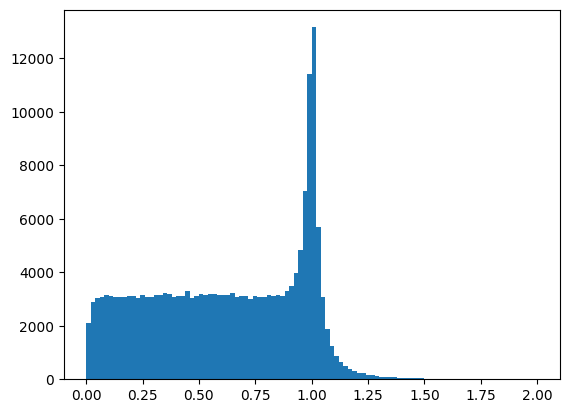

In [ ]:
vbf_quark_last_pt=ak.flatten(genparts_flat[vbf_quark_last_idx].pt)
vbf_quark_first_pt=ak.flatten(genparts_flat[vbf_quark_idx].pt)
print(vbf_quark_last_pt)
#plot ratio of pt of last copy of quark to the pt of the quark
plt.hist(vbf_quark_last_pt/vbf_quark_first_pt, bins=100, range=(0,2))

(array([   72.,    62.,    58.,    75.,    85.,    64.,    80.,    95.,
          105.,    97.,    92.,   110.,   111.,   125.,   132.,   134.,
          145.,   143.,   145.,   146.,   189.,   195.,   201.,   199.,
          226.,   274.,   311.,   320.,   328.,   344.,   435.,   451.,
          527.,   553.,   653.,   692.,   793.,   872.,  1028.,  1180.,
         1461.,  1685.,  2068.,  2661.,  3357.,  4487.,  6170.,  9423.,
        16244., 25773., 36764., 16986., 10271.,  7169.,  5454.,  4192.,
         3355.,  2807.,  2298.,  1941.,  1679.,  1487.,  1298.,  1152.,
         1013.,   900.,   790.,   754.,   732.,   552.,   585.,   503.,
          463.,   454.,   366.,   383.,   334.,   298.,   290.,   279.,
          252.,   267.,   241.,   191.,   202.,   212.,   180.,   189.,
          170.,   159.,   140.,   133.,   131.,   134.,   121.,   111.,
          111.,   108.,    95.,   125.]),
 array([0.5       , 0.50999999, 0.51999998, 0.52999997, 0.54000002,
        0.55000001, 0.56  

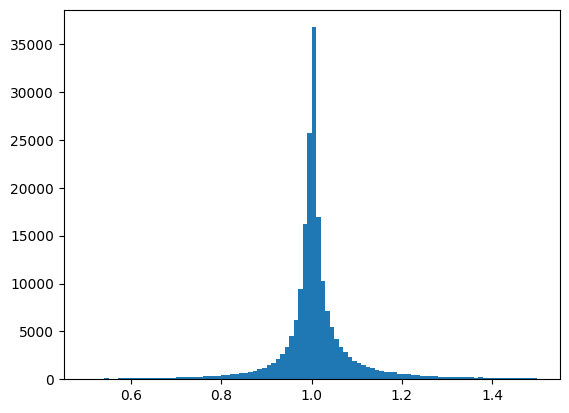

In [ ]:
# plot ratio of eta of last copy of quark to the eta of the quark
vbf_quark_last_eta=ak.flatten(genparts_flat[vbf_quark_last_idx].eta)
vbf_quark_first_eta=ak.flatten(genparts_flat[vbf_quark_idx].eta)
plt.hist(vbf_quark_last_eta/vbf_quark_first_eta, bins=100, range=(0.5,1.5))


(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 200000.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

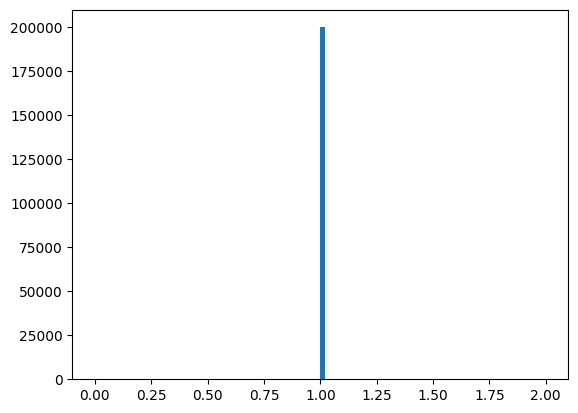

In [ ]:
#ratio of pdgId of last copy of quark to the pdgId of the quark
vbf_quark_last_pdgId=ak.flatten(genparts_flat[vbf_quark_last_idx].pdgId)
vbf_quark_first_pdgId=ak.flatten(genparts_flat[vbf_quark_idx].pdgId)
plt.hist(vbf_quark_last_pdgId/vbf_quark_first_pdgId, bins=100, range=(0,2))


# TEST

In [ ]:
quark_last=(genpart[isQuark & isHard & (genpart.genPartIdxMother!=-1)& genpart.hasFlags(["isLastCopy"])])
quark_last_flatten=ak.flatten(quark_last)
print(quark_last.pdgId, quark_last.genPartIdxMother, quark_last.index,len(quark_last_flatten))

[[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... -1, 5, 5, -5, 1], [5, -5, 1, 2, 5, -5]] [[14, 5, 4, 15, 17, 13], [15, 14, 5, 16, ... 12, 15, 16, 4], [9, 9, 5, 4, 10, 11]] [[18, 20, 21, 24, 26, 29], [18, 20, 22, ... 27, 28, 31], [12, 13, 14, 16, 19, 21]] 600410


In [ ]:
quark_last_mother = (genpart[quark_last.genPartIdxMother])
quark_last_mother_flatten=ak.flatten(quark_last_mother)
print(quark_last_mother.pdgId, quark_last_mother.children.pdgId, quark_last_mother.children.index, len(quark_last_mother_flatten.pdgId))

[[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... -1, 5, 5, -5, 1], [25, 25, 1, 2, 5, -5]] [[[5, -523, 21, 21, 521], [2], [2], [-5, ... 1, 221], [2], [5], [21, -5, -511, 523]]] [[[18, 19, 22, 23, 25], [20], [21], [24], ... 14, 15], [16], [19], [20, 21, 22, 23]]] 600410


In [ ]:
# get mother of mother
quark_mother_not_null=quark_last[quark_last_mother.genPartIdxMother!=-1]
quark_mother_not_null_flatten=ak.flatten(quark_mother_not_null)
mother_not_null=quark_last_mother[quark_last_mother.genPartIdxMother!=-1]
mother_not_null_flatten=ak.flatten(mother_not_null)
quark_last_mother_mother = genpart[mother_not_null.genPartIdxMother]
quark_last_mother_mother_flatten=ak.flatten(quark_last_mother_mother)
print(quark_last_mother_mother.pdgId, quark_last_mother_mother.children.pdgId, quark_last_mother_mother.children.index, len(quark_last_mother_mother.pdgId))

[[25, 2, 2, 25, 5, 25], [25, 25, 1, 25, ... 25, 25, 25, -2], [25, 25, 2, 2, 25, 25]] [[[5, -5], [25, 25, 2, 2], [25, 25, 2, 2], ... 1], [25, 25, 2, 1], [5, -5], [5, -5]]] [[[14, 15], [2, 3, 4, 5], [2, 3, 4, 5], ... 5], [2, 3, 4, 5], [10, 11], [10, 11]]] 100000


/work/mmalucch/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


(array([2.5520e+03, 3.1500e+03, 3.5220e+03, 3.6800e+03, 3.9430e+03,
        4.0150e+03, 4.1300e+03, 4.1770e+03, 4.3120e+03, 4.4440e+03,
        4.5880e+03, 4.6640e+03, 4.9190e+03, 4.9010e+03, 4.9550e+03,
        5.0870e+03, 5.3700e+03, 5.5560e+03, 5.5640e+03, 5.7180e+03,
        5.8690e+03, 6.1280e+03, 6.4100e+03, 6.3640e+03, 6.4950e+03,
        6.9900e+03, 7.1080e+03, 7.4440e+03, 7.6560e+03, 8.0870e+03,
        8.3880e+03, 8.8360e+03, 9.3060e+03, 9.6310e+03, 1.0157e+04,
        1.0822e+04, 1.1339e+04, 1.2087e+04, 1.2862e+04, 1.3779e+04,
        1.4888e+04, 1.6453e+04, 1.7818e+04, 1.9589e+04, 2.1530e+04,
        2.4503e+04, 2.7431e+04, 3.1861e+04, 3.8442e+04, 4.1298e+04,
        5.1361e+04, 7.2900e+03, 4.1610e+03, 2.7260e+03, 1.9930e+03,
        1.4750e+03, 1.1570e+03, 9.5700e+02, 8.4300e+02, 6.8200e+02,
        5.6300e+02, 5.7700e+02, 4.5900e+02, 4.2900e+02, 3.5900e+02,
        3.1800e+02, 2.9200e+02, 2.5500e+02, 2.3400e+02, 2.3100e+02,
        2.1700e+02, 1.9000e+02, 2.1000e+02, 1.83

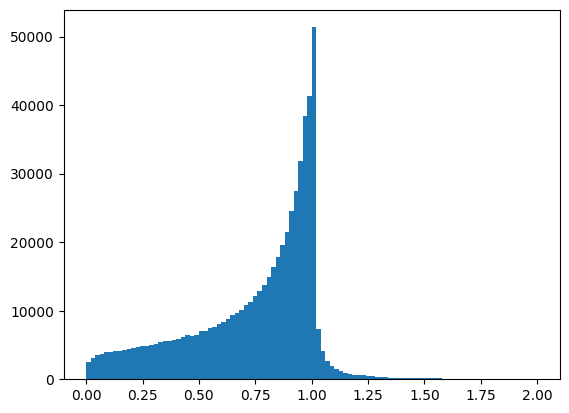

In [ ]:
#plot pt ratio of last copy of quark to the pt of the mother
plt.hist(quark_last_flatten.pt/quark_last_mother_flatten.pt, bins=100, range=(0,2))

/work/mmalucch/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


(array([  364.,  1099.,  1666.,  2216.,  2652.,  3128.,  3441.,  3617.,
         3976.,  4202.,  4267.,  4419.,  4636.,  4730.,  4830.,  5101.,
         5005.,  5274.,  5127.,  5148.,  5272.,  5370.,  5427.,  5357.,
         5352.,  5675.,  5607.,  5712.,  5633.,  5679.,  5794.,  5776.,
         5902.,  5992.,  5955.,  6111.,  6279.,  6205.,  6510.,  6322.,
         6636.,  6546.,  6894.,  7090.,  7301.,  7465.,  7894.,  8441.,
         9242., 12799., 15153.,  5926.,  5343.,  5048.,  4747.,  4570.,
         4312.,  3963.,  3645.,  3451.,  3271.,  3100.,  2944.,  2703.,
         2569.,  2535.,  2273.,  2191.,  2132.,  1904.,  1995.,  1946.,
         1706.,  1681.,  1462.,  1573.,  1467.,  1294.,  1311.,  1246.,
         1237.,  1081.,  1107.,   995.,  1005.,   941.,   945.,   871.,
          890.,   809.,   775.,   776.,   789.,   719.,   691.,   668.,
          597.,   626.,   562.,   643.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12  

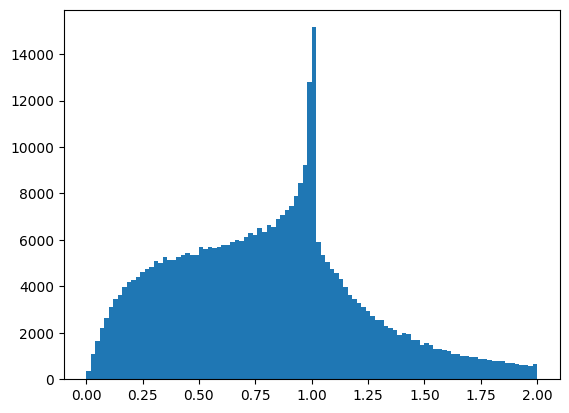

In [ ]:
plt.hist(mother_not_null_flatten.pt/quark_last_mother_mother_flatten.pt, bins=100, range=(0,2))

(array([1209., 2992., 4041., 4782., 5525., 5952., 6098., 6474., 6676.,
        6768., 6849., 7077., 7130., 7056., 7136., 7256., 7296., 7296.,
        7130., 7113., 6998., 7257., 7030., 7030., 6822., 7223., 6960.,
        6820., 6831., 6737., 6785., 6776., 6715., 6795., 6711., 6637.,
        6497., 6690., 6675., 6437., 6519., 6492., 6504., 6391., 6702.,
        6739., 6568., 6820., 6890., 6428., 5103., 3878., 3530., 3253.,
        3144., 2861., 2621., 2521., 2395., 2152., 2092., 2064., 1782.,
        1729., 1666., 1618., 1583., 1439., 1333., 1321., 1197., 1169.,
        1134., 1123.,  950.,  995.,  911.,  899.,  832.,  770.,  754.,
         750.,  708.,  641.,  689.,  652.,  624.,  588.,  580.,  540.,
         506.,  527.,  515.,  485.,  459.,  421.,  428.,  400.,  404.,
         461.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18000001,
        0.2       , 0.22      , 0.23999999, 0.25999999, 0.28      

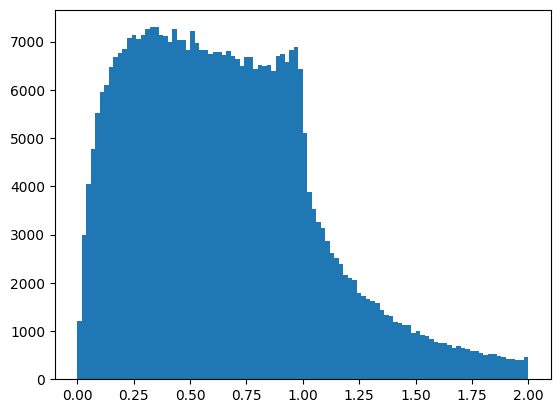

In [ ]:
plt.hist(quark_mother_not_null_flatten.pt/quark_last_mother_mother_flatten.pt, bins=100, range=(0,2))

# check if it can happen that multiple children of a particle have the same pdgId has the parent

In [ ]:
isQuark = abs(genpart.pdgId) < 7
isHard = genpart.hasFlags(["fromHardProcess"])

quarks = genpart[isQuark & isHard]

quarks = quarks[quarks.genPartIdxMother!=-1]

quarks_mother = genpart[quarks.genPartIdxMother]
quarks_mother_children = quarks_mother.children
quarks_mother_children_isH = ak.sum((quarks_mother_children.pdgId == 25), axis=-1)==2
vbf_quarks = quarks[quarks_mother_children_isH]

print("vbf_quarks children", vbf_quarks.children.pdgId)


children_pdgId = genpart.children.pdgId
parent_pdgId = genpart.pdgId

print(parent_pdgId)
print(children_pdgId)

for event in range(len(vbf_quarks)):
    # for i in range(len(vbf_quarks[event])):
    for i in vbf_quarks[event].index:
        if (
            # True
            ak.sum(parent_pdgId[event][i] == children_pdgId[event][i]) > 1
            and not ak.any(children_pdgId[event][i] == 25)
            and ak.sum(genpart[event][i].children.hasFlags(["fromHardProcess"])) > 1
        ):
            print("Event", event, "Particle", i)
            print("Parent pdg", parent_pdgId[event][i])
            print("Children pdg", children_pdgId[event][i])
            print("chilren index", genpart[event][i].children.index)
            print("children pt", genpart[event][i].children.pt)
            # print("children is last copy", genpart[event][i].children.hasFlags(["isLastCopy"]))
            print(
                "children from hard",
                genpart[event][i].children.hasFlags(["fromHardProcess"]),
            )
            print(
                "children is hard",
                genpart[event][i].children.hasFlags(["isHardProcess"]),
            )
            print(
                "children is prompt", genpart[event][i].children.hasFlags(["isPrompt"])
            )

            print("parent index", genpart[event][i].index)
            print("childre mother index", genpart[event][i].children.genPartIdxMother)

vbf_quarks children [[[2], [2]], [[2], [1]], [[4, 421], ... 21]], [[1, 111], [-1]], [[2], [1, 221]]]
[[2, 2, 25, 25, 2, 2, 25, 25, 25, 25, ... -11, 12, -13, 14, -421, 111, 111, 22, 22]]
[[[25, 25, 2, 2], [], [25], [25], [2], [2, ... [], [], [], [], [22], [22], [], []]]
Event 1118 Particle 5
Parent pdg -4
Children pdg [-4, -4, 21]
chilren index [14, 15, 25]
children pt [24, 29.9, 7.34]
children from hard [True, True, False]
children is hard [False, False, False]
children is prompt [True, True, True]
parent index 5
childre mother index [5, 5, 5]
Event 1662 Particle 4
Parent pdg 4
Children pdg [4, 4, 421, 111]
chilren index [14, 24, 34, 49]
children pt [66.2, 37, 23.7, 25.8]
children from hard [True, True, False, False]
children is hard [False, False, False, False]
children is prompt [True, True, True, False]
parent index 4
childre mother index [4, 4, 4, 4]
Event 5891 Particle 4
Parent pdg 4
Children pdg [4, 4, 413]
chilren index [14, 29, 51]
children pt [14.7, 15.8, 9.25]
children from h

KeyboardInterrupt: 